<a href="https://colab.research.google.com/github/Shyams728/machine_learning_projects/blob/main/toxic_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Toxic Tweets Dataset : NLP Problem
This dataset has a collection of Tweets. Its labelled as Toxic - 1, Non toxic - 0. Apply the NLP

methods to predict the toxicity of the tweets. Download the dataset from the following Kaggle Com-
pitation https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset. All

the credits to the original collectors.
Procedure:
1. Convert the CSV file to the panda data frame.
2. Convert the text to the following.
• Bag of Words
• TF-IDF
3. For the obtained features, apply the following methods of prediction.
• Decision Trees
• Random forest
• Naive Bayes Model
• K-NN Classifier
• SVM
4. For each of this method produce the following metrics:
• Precision, Recall, F1 - Score
• Confusion Matrix
• RoC - AUC curve

In [2]:
!unzip /content/drive/MyDrive/data/FinalBalancedDataset.csv.zip -d /content/tweet_dataset

Archive:  /content/drive/MyDrive/data/FinalBalancedDataset.csv.zip
  inflating: /content/tweet_dataset/FinalBalancedDataset.csv  


In [5]:
# Import necessary libraries
import string
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources if not already downloaded
nltk.download('wordnet')
nltk.download('stopwords')

# Step 1: Load the dataset
df = pd.read_csv('/content/tweet_dataset/FinalBalancedDataset.csv')

# Step 2: Data Exploration
# Check class distribution
class_distribution = df['Toxicity'].value_counts()
print("Class Distribution: ", class_distribution)

# Step 3: Data Splitting
# Use cross-validation for model evaluation
from sklearn.model_selection import cross_val_score

# Step 4: Text Preprocessing
def remove_unwanted_chars(text):
    # Remove punctuations and digits
    unwanted_chars = string.punctuation + string.digits
    cur_text = "".join([char.lower() if char not in unwanted_chars else " " for char in text])
    return " ".join(cur_text.split())

def preprocess_text(text):
    # Tokenize, lemmatize, and remove stopwords
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    tokens = tokenizer.tokenize(text)
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(clean_tokens)

# Apply preprocessing to the 'tweet' column and create a new 'clean_tweet' column
df['clean_tweet'] = df['tweet'].apply(remove_unwanted_chars).apply(preprocess_text)

# Step 5: Feature Extraction
# Create a TF-IDF representation of text data into numerical vectors
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_tweet'])

# Create a Bag of Words (BoW) representation text data into numerical vectors using a CountVectorizer
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(df['clean_tweet'])

def plot_roc_curve(fpr, tpr, auc, model_name):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

def plot_confusion_matrix(matrix, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()




def model_training_and_evaluation(x, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Handle imbalanced data
    oversampler = RandomOverSampler()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    classifiers = [
        DecisionTreeClassifier(random_state=42, criterion='entropy'),
        RandomForestClassifier(random_state=42),
        MultinomialNB(),
        KNeighborsClassifier(),
        SVC(probability=True)
    ]

    results = []
    for classifier in tqdm(classifiers, desc="Processing algorithm",unit="model", total=len(classifiers)):
        model_name = classifier.__class__.__name__

        # Use a pipeline for better organization
        if 'SVC' in model_name:
            model = make_pipeline(StandardScaler(with_mean=False), classifier)
        else:
            model = classifier

        # Fit the classifier on the training data
        model.fit(X_train_resampled, y_train_resampled)

        # Predict on the test data
        y_pred = model.predict(X_test)

        # Calculate various evaluation metrics
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        confusion_matrix_result = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        print(f"Model: {model_name}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print(f"ROC-AUC: {roc_auc}")

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plot_roc_curve(fpr, tpr, roc_auc, model_name)

        # Plot confusion matrix
        plot_confusion_matrix(confusion_matrix_result, model_name)

        results.append([model_name, precision, recall, f1, confusion_matrix_result, roc_auc])
        time.sleep(0.1)

    results_df = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'Confusion Matrix', 'ROC-AUC'])

    return results_df


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Class Distribution:  0    32592
1    24153
Name: Toxicity, dtype: int64


Processing algorithm:   0%|          | 0/5 [00:00<?, ?model/s]

Model: DecisionTreeClassifier
Precision: 0.9336036539219447
Recall: 0.9336505418979646
F1-Score: 0.9335809020345136
ROC-AUC: 0.9316960041495448


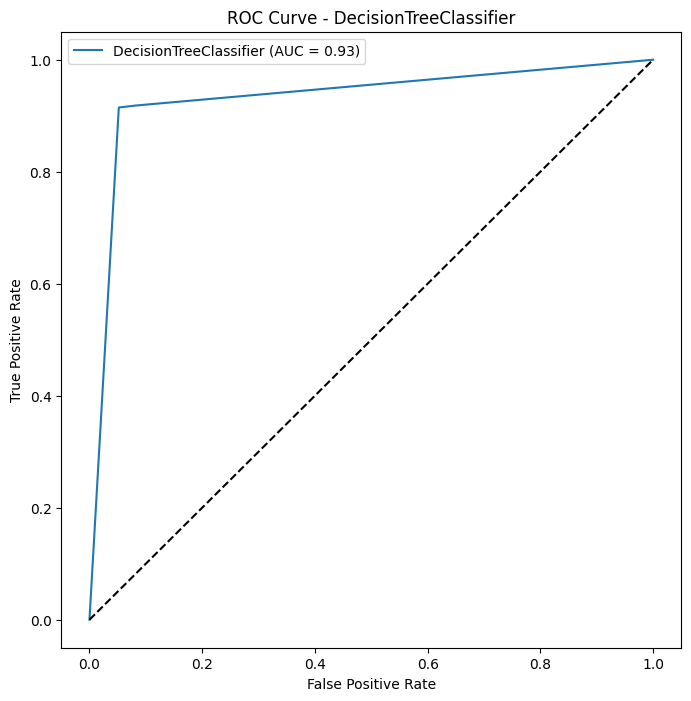

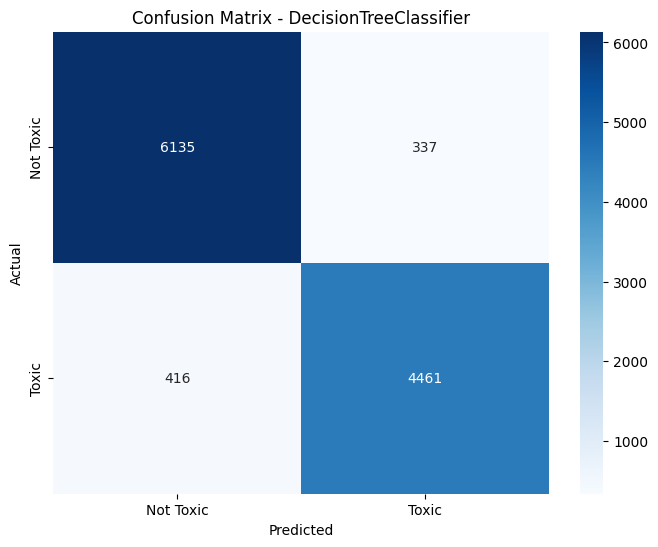

Processing algorithm:  20%|██        | 1/5 [00:14<00:56, 14.16s/model]

Model: RandomForestClassifier
Precision: 0.9380285864355624
Recall: 0.9380562164067319
F1-Score: 0.937980763899338
ROC-AUC: 0.9820379861274624


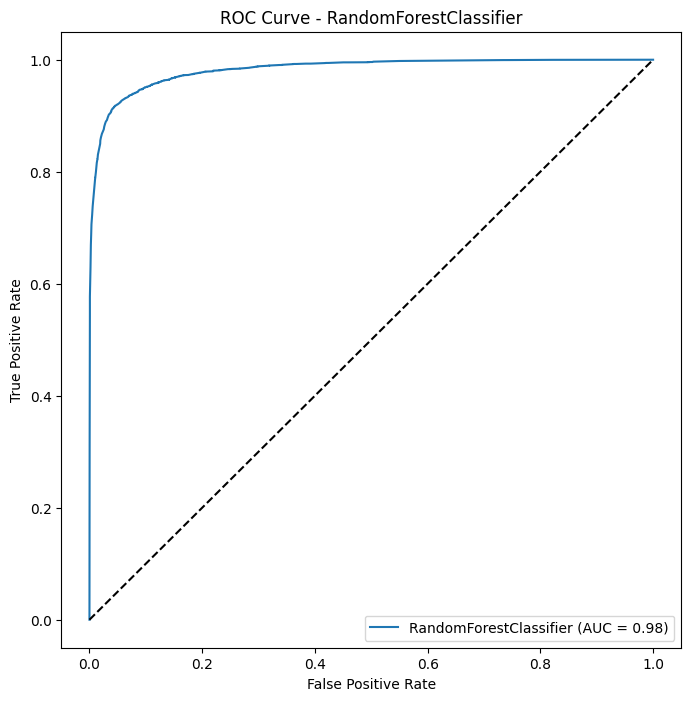

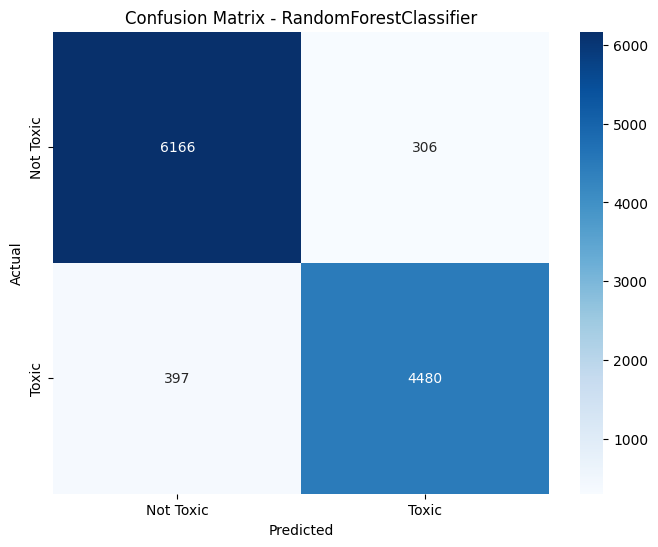

Processing algorithm:  40%|████      | 2/5 [03:37<06:15, 125.25s/model]

Model: MultinomialNB
Precision: 0.9078224947774616
Recall: 0.9031632742972949
F1-Score: 0.9035877704762006
ROC-AUC: 0.971187187507366


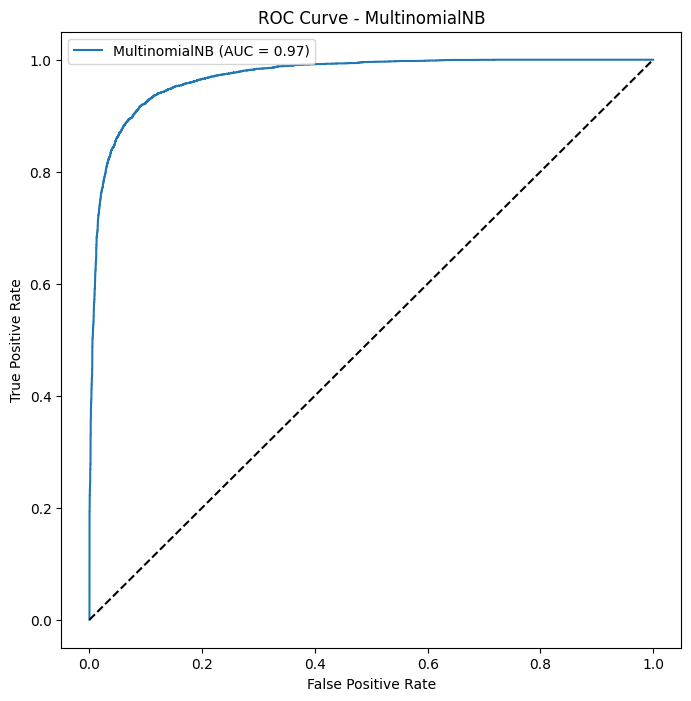

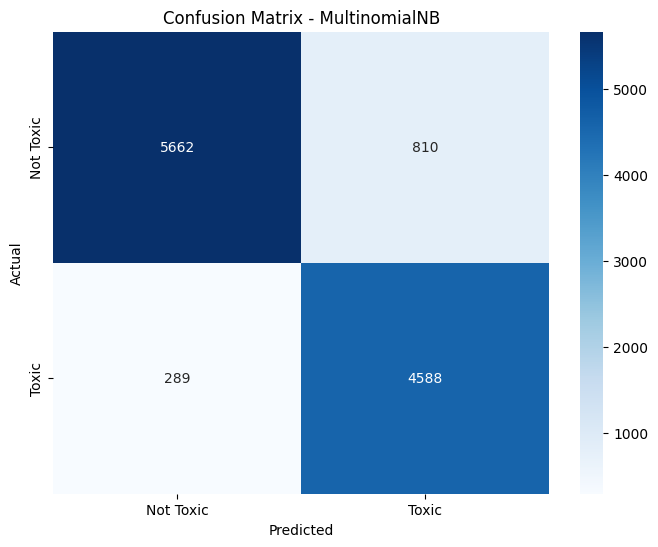

Processing algorithm:  60%|██████    | 3/5 [03:37<02:16, 68.29s/model] 

Model: KNeighborsClassifier
Precision: 0.7313174990483102
Recall: 0.6305401356947749
F1-Score: 0.545315558721104
ROC-AUC: 0.6899495671390116


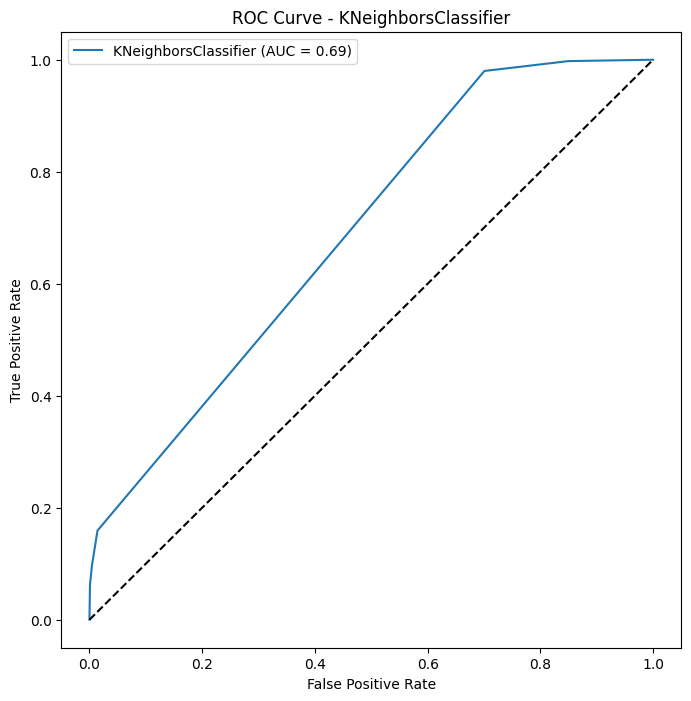

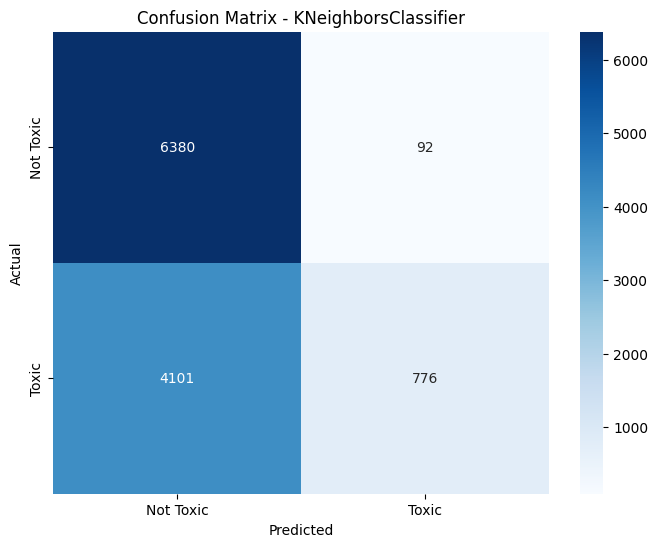

Processing algorithm:  80%|████████  | 4/5 [05:31<01:26, 86.14s/model]

Model: SVC
Precision: 0.87800555629816
Recall: 0.8781390430874967
F1-Score: 0.8780513279972142
ROC-AUC: 0.9512797893697948


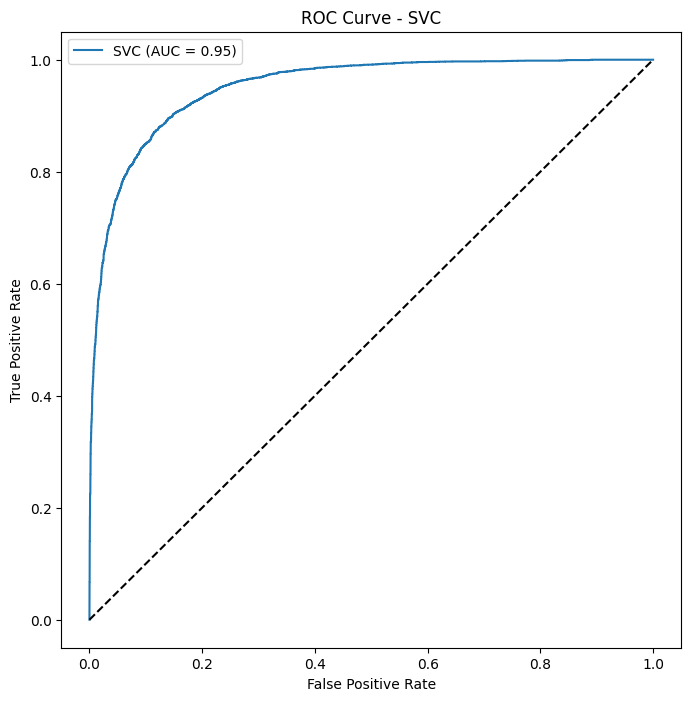

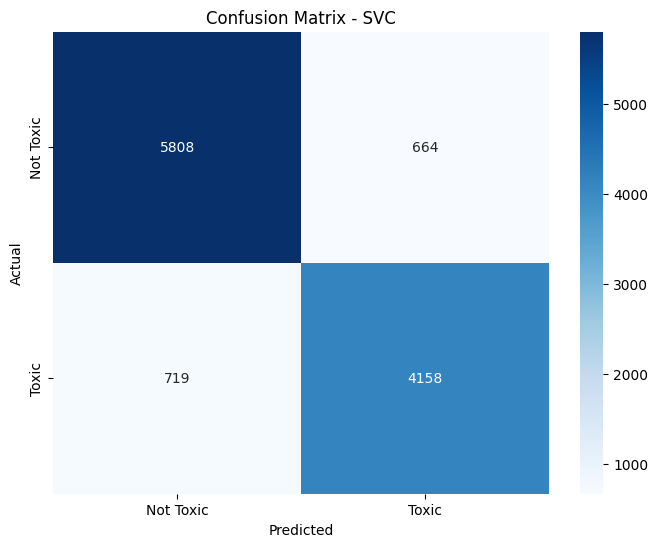

Processing algorithm: 100%|██████████| 5/5 [1:00:50<00:00, 730.05s/model] 


In [6]:
tfidf = model_training_and_evaluation(X_tfidf, df['Toxicity'])

In [ ]:
tfidf

In [ ]:
tfidf = model_training_and_evaluation(X_tfidf, df['Toxicity'])
bow = model_training_and_evaluation(X_bow, df['Toxicity'])

Processing algorithm:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
bow = model_training_and_evaluation(X_bow, df['Toxicity'])

,Model,Precision,Recall,F1-Score,Confusion Matrix,ROC-AUC
0,DecisionTreeClassifier,0.931757,0.931800,0.931716,"[[6131, 341], [433, 4444]]",0.929588
1,RandomForestClassifier,0.938507,0.938497,0.938398,"[[6182, 290], [408, 4469]]",0.982434
2,MultinomialNB,0.915553,0.915587,0.915568,"[[6002, 470], [488, 4389]]",0.971078
3,KNeighborsClassifier,0.738891,0.618645,0.519703,"[[6422, 50], [4278, 599]]",0.680692


In [ ]:
bow

,Model,Precision,Recall,F1-Score,Confusion Matrix,ROC-AUC
0,DecisionTreeClassifier,0.934328,0.934267,0.934131,"[[6174, 298], [448, 4429]]",0.931260
1,RandomForestClassifier,0.939121,0.939114,0.939018,"[[6184, 288], [403, 4474]]",0.982527
2,MultinomialNB,0.919028,0.917173,0.917430,"[[5849, 623], [317, 4560]]",0.972656
3,KNeighborsClassifier,0.902532,0.896026,0.894380,"[[6287, 185], [995, 3882]]",0.936653


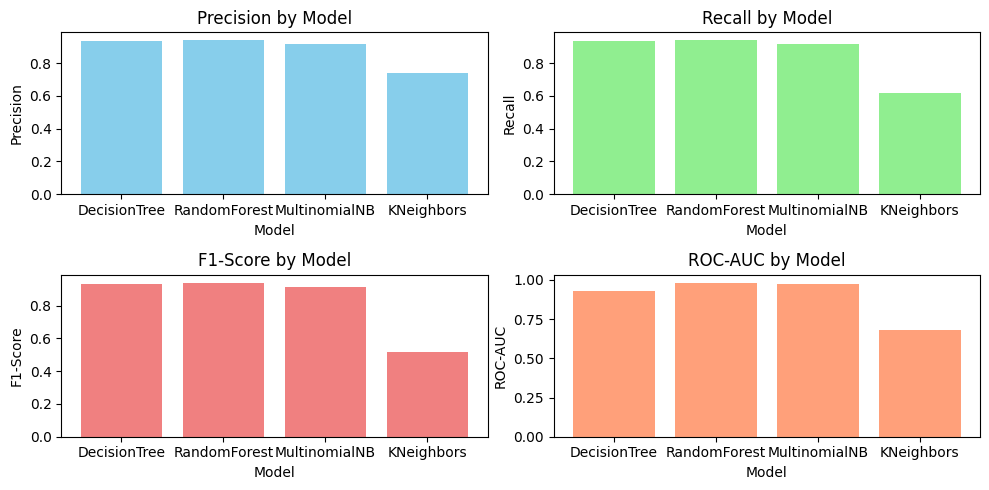

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data with the DataFrame
data = {
    'Model': ['DecisionTree', 'RandomForest', 'MultinomialNB', 'KNeighbors'],
    'Precision': [0.933623, 0.941226, 0.915553, 0.739525],
    'Recall': [0.933651, 0.941228, 0.915587, 0.618733],
    'F1-Score': [0.933558, 0.941145, 0.915568, 0.519761],
    'ROC-AUC': [0.931389, 0.983354, 0.971078, 0.680695],
}

df = pd.DataFrame(data)

# Set the figure size
plt.figure(figsize=(10, 5))

# Create subplots for each metric
plt.subplot(2, 2, 1)
plt.bar(df['Model'], df['Precision'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision by Model')

plt.subplot(2, 2, 2)
plt.bar(df['Model'], df['Recall'], color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall by Model')

plt.subplot(2, 2, 3)
plt.bar(df['Model'], df['F1-Score'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score by Model')

plt.subplot(2, 2, 4)
plt.bar(df['Model'], df['ROC-AUC'], color='lightsalmon')
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC by Model')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()


In [ ]:
import string
string.punctuation + string.digits

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [ ]:
# applying remove_unwanted_chars on dataframe df and removing all the punctuations and numbers from the tweets
df['cur_tweet'] = df['tweet'].apply(lambda tweet_data:remove_unwanted_chars(tweet_data))

In [ ]:
df

,Toxicity,tweet,cur_tweet
0,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is so ...
1,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can t use c...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in urð...
4,0,factsguide: society now #motivation,factsguide society now motivation
...,...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you s a muthaf in lie lifeasking pearls corey ...
56741,1,"you've gone and broke the wrong heart baby, an...",you ve gone and broke the wrong heart baby and...
56742,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like i aint fu...
56743,1,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


A lemmatizer is a linguistic tool or algorithm used in natural language processing (NLP) and computational linguistics to reduce words to their base or dictionary form, known as the "lemma." The purpose of lemmatization is to normalize words so that different inflected forms or variations of a word all map to the same root word.

For example, in English:

"running," "ran," and "runs" would all be lemmatized to the base form "run."
"better" and "best" would both be lemmatized to "good."
Lemmatization is often used in NLP to:

**Reduce Dimensionality: **
By converting words to their base forms, it reduces the number of unique words in a text corpus, which can help with text analysis, classification, and clustering.

_Improve Text Analysis:_ Lemmatized text can be easier to analyze and interpret because it reduces the complexity introduced by various inflections.

_Enhance Information Retrieval:_ When searching for information in a text corpus or building search engines, lemmatization ensures that different forms of a word are treated as the same, leading to more accurate results.